# from .out file to a plot of mutation directions

put full path to Variants.out file, desired coverage cutoff, and desired minimum variant frequency below

In [21]:
path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Variants9.out"

coverage_threshold = 100

minimum_frequency = 0.1

0.1

In [22]:
# read in .out files to a dataframe

using DelimitedFiles
using DataFrames

function read_out_file(filename::AbstractString; delim::Char=' ')
    data = readdlm(filename, delim, Int)
    col_names = [:pos, :A, :C, :G, :T, :n]
    df = DataFrame(data, col_names)
    return df
end

out = read_out_file(path)

Row,pos,A,C,G,T,n
,Int64,Int64,Int64,Int64,Int64,Int64
1,1,158,0,0,0,158
2,2,160,0,0,0,160
3,3,160,0,0,2,162
4,4,0,199,0,0,199
5,5,0,0,0,201,201
6,6,0,2,0,211,213
7,7,0,0,238,0,238
8,8,0,260,0,1,261
9,9,0,0,280,0,280


In [23]:
# filter out low coverage and by minimum variant threshold
# function to filter out positions with low coverage
function filter_coverage(df::DataFrame, threshold::Int)
    return filter(row -> row.n >= threshold, df)
end

# look for variants at > minimum frequency
function filter_positions(df::DataFrame, proportion::Float64)
    # Validate that the required columns are present in the DataFrame
    required_columns = ["A", "C", "G", "T", "n"]
    for col in required_columns
        if !(col in names(df))
            error("DataFrame must contain the columns: A, C, G, T, and n")
        end
    end
    
    # Function to check if any of three smallest columns are greater than n * proportion
    function check_proportion(row)
        values = [row.A, row.C, row.G, row.T]
        sorted_indices = sortperm(values, rev=true)  # Sort indices based on values descending
        max_index = sorted_indices[1]                # Index of the maximum value
        remaining_values = deleteat!(values, max_index)  # Remove the maximum value
        
        # Check if any remaining value exceeds n * proportion
        return any(v -> v > row.n * proportion, remaining_values)
    end
    
    # Filter rows based on the check_proportion function
    return filter(check_proportion, df)
end

filtered = filter_coverage(out, coverage_threshold)
filtered = filter_positions(filtered, minimum_frequency)

Row,pos,A,C,G,T,n
,Int64,Int64,Int64,Int64,Int64,Int64
1,18,238,0,94,0,332
2,380,2,578,2,3499,4081
3,1082,965,11,4666,5,5647
4,1365,1888,10317,1,2,12208
5,1472,4,6529,0,1200,7733
6,2403,6,6576,2,980,7564
7,2454,2,5245,0,1263,6510
8,3072,11,10136,0,2122,12269
9,3361,5,3466,7,20808,24286


In [24]:
# pull out variants
# function to pull out the variants in an easier format
function pull_variants(df::DataFrame)
    # Define the result DataFrame with the specified columns
    result_df = DataFrame(pos = Int[], original_base = String[], variant_base = String[], freq = Float64[])
    
    # Process each row of the input DataFrame
    for row in eachrow(df)
        pos = row[:pos]
        bases = [:A, :C, :G, :T]
        counts = [row.A, row.C, row.G, row.T]
        
        # Sort bases by their counts in descending order
        sorted_indices = sortperm(counts, rev=true)
        
        # Find the bases with the highest and second highest counts
        highest_base = bases[sorted_indices[1]]
        second_highest_base = bases[sorted_indices[2]]
        
        # Calculate the frequency of the second highest base
        freq = counts[sorted_indices[2]] / row.n
        
        # Append the results to the DataFrame, converting symbols to strings
        push!(result_df, (pos, string(highest_base), string(second_highest_base), freq))
    end
    
    return result_df
end

# function for a mutation column
using CategoricalArrays

function call_muts(df::DataFrame)
    # Check if the required columns are present in the DataFrame
    if !("original_base" in names(df) && "variant_base" in names(df))
        error("DataFrame must contain 'original_base' and 'variant_base' columns")
    end

    # Create a new column 'mutation' by concatenating 'original_base', '->', 'variant_base'
    # and convert it to a categorical array
    df.mutation = categorical(df.original_base .* "->" .* df.variant_base)
    
    return df
end

variants = pull_variants(filtered)
variants = call_muts(variants)


Row,pos,original_base,variant_base,freq,mutation
,Int64,String,String,Float64,Cat…
1,18,A,G,0.283133,A->G
2,380,T,C,0.141632,T->C
3,1082,G,A,0.170887,G->A
4,1365,C,A,0.154653,C->A
5,1472,C,T,0.155179,C->T
6,2403,C,T,0.129561,C->T
7,2454,C,T,0.194009,C->T
8,3072,C,T,0.172956,C->T
9,3361,T,C,0.142716,T->C


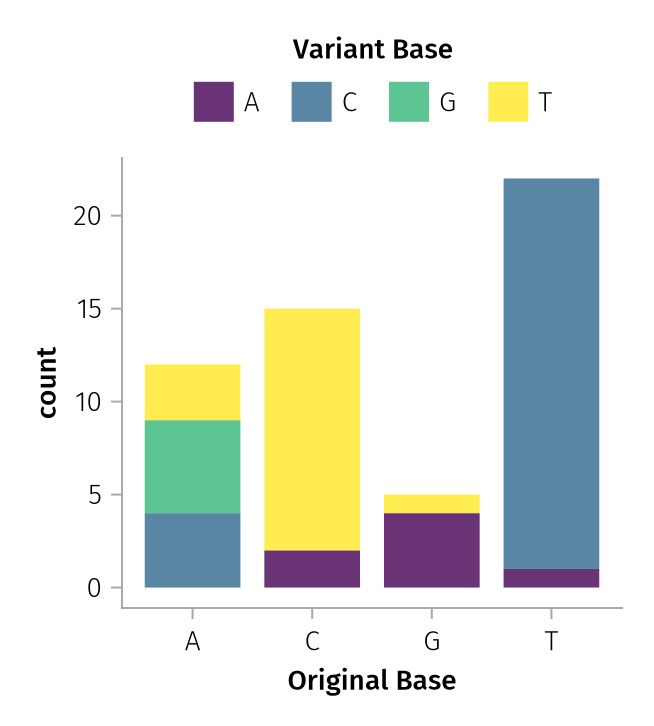

In [25]:
# try using AoG for plotting inside Julia
using AlgebraOfGraphics, CairoMakie
using Colors
set_aog_theme!()

axis = (width = 250, height = 225, xlabel = "Original Base")

mutation_frequency = data(variants) * frequency() * mapping(:original_base, color = :variant_base => "Variant Base", stack = :variant_base)
colors = ["A" => colorant"#440154CC", "C" => colorant"#31688ECC", "G" => colorant"#35B779CC", "T" => colorant"#FDE725CC"]
draw(mutation_frequency; palettes=(color=colors,), axis = axis, legend=(position=:top, titleposition=:top))